In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shakyadissanayake_oily_dry_and_normal_skin_types_dataset_path = kagglehub.dataset_download('shakyadissanayake/oily-dry-and-normal-skin-types-dataset')

print('Data source import complete.')
# https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/data


100%|██████████| 124M/124M [00:01<00:00, 84.7MB/s]


Extracting files...
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [ ]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

# Creating dataset

In [ ]:
train_df = create_df("/root/.cache/kagglehub/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/versions/1/Oily-Dry-Skin-Types/train")
val_df = create_df("/root/.cache/kagglehub/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/versions/1/Oily-Dry-Skin-Types/valid")
test_df = create_df("/root/.cache/kagglehub/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/versions/1/Oily-Dry-Skin-Types/test")

In [ ]:
train_df = pd.concat([train_df, val_df, test_df])

# Defining training parameters

In [ ]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [ ]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [ ]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [ ]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Downloading ResNet50

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Training tools

In [ ]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04660139505657966 acc 0.42324474414914715 val loss 0.035397667355007593 acc 0.49523809523809526
Epochs 2 train loss 0.024318487090470534 acc 0.6556921856406188 val loss 0.027703794978913808 acc 0.6126984126984127
Epochs 3 train loss 0.01550834269241793 acc 0.7996826656088853 val loss 0.027589869688427637 acc 0.6476190476190476
Epochs 4 train loss 0.010905038250646436 acc 0.8667195557318524 val loss 0.02342001237566509 acc 0.7682539682539683
Epochs 5 train loss 0.007791916114595475 acc 0.9190797302657675 val loss 0.03711124999182565 acc 0.6253968253968254
Epochs 6 train loss 0.005841784146701188 acc 0.9393097976993257 val loss 0.020490166402998423 acc 0.7841269841269841
Epochs 7 train loss 0.0035502624401334303 acc 0.9642998809996033 val loss 0.03701324311513749 acc 0.6349206349206349
Epochs 8 train loss 0.0027103234530943387 acc 0.9742165807219357 val loss 0.022380996034258888 acc 0.7936507936507936
Epochs 9 train loss 0.0021276318723796165 acc 0.9801666005553352 

# Model's performance log

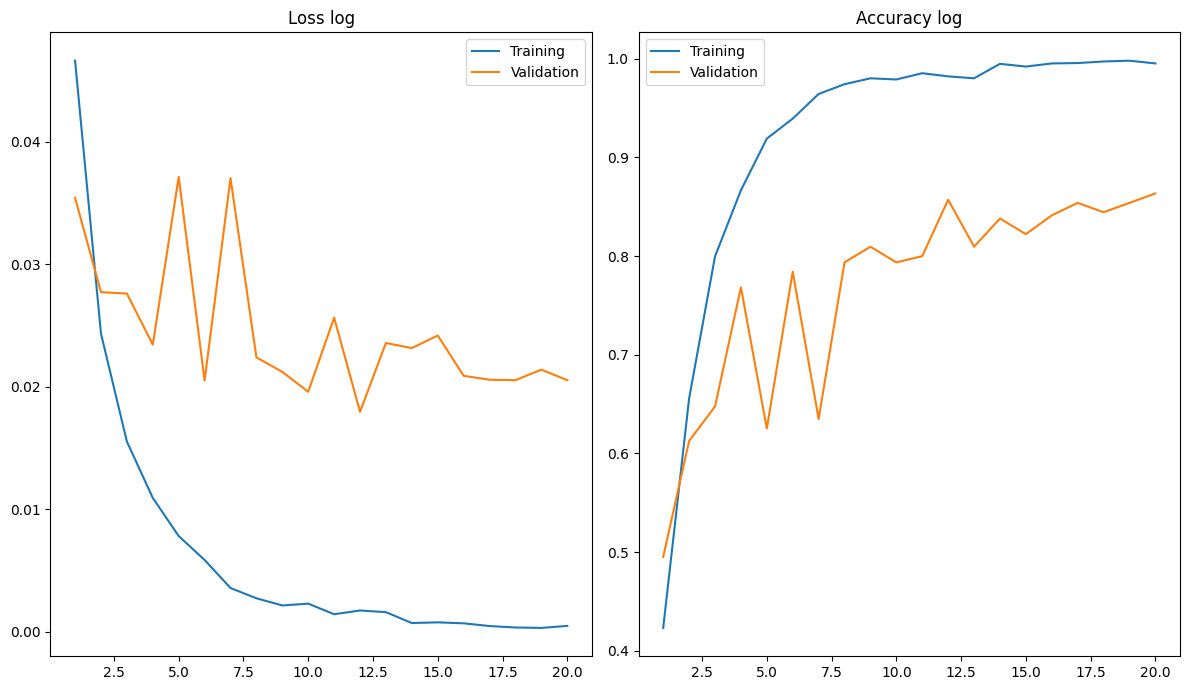

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [ ]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [ ]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

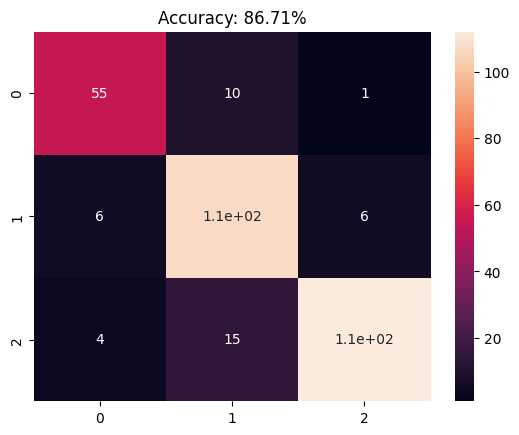

In [ ]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        66
           1       0.81      0.90      0.85       119
           2       0.94      0.85      0.90       131

    accuracy                           0.87       316
   macro avg       0.87      0.86      0.86       316
weighted avg       0.87      0.87      0.87       316



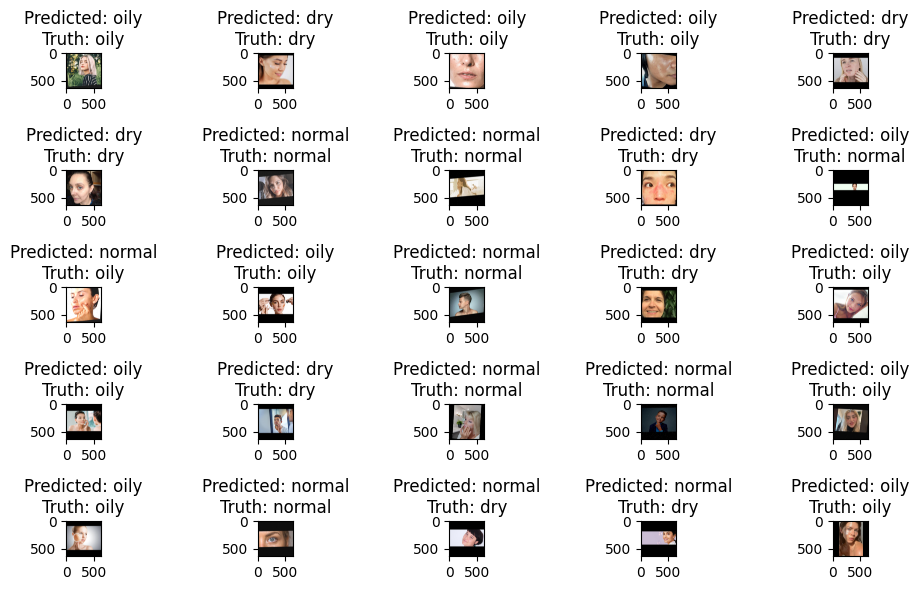

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Load the trained model
model_path = '/content/skin_type_resnet50.pth'
best_model.load_state_dict(torch.load(model_path))
best_model.to(device)
best_model.eval()

def predict_image(image_path, model, transform, device):
    img = Image.open(image_path).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)

    with torch.no_grad():
        if device == "cuda":
            img = img.cuda()

        out = model(img)
        return out.argmax(1).item()

# Example usage with a sample image path (replace with the actual image path)
image_path_to_predict = '/content/girl.jpg' # Replace with the path to your imageq

# Check if the image file exists
if os.path.exists(image_path_to_predict):
    predicted_label_index = predict_image(image_path_to_predict, best_model, transform, device)
    predicted_label = index_label[predicted_label_index]
    print(f"Predicted skin type for {image_path_to_predict}: {predicted_label}")
else:
    print(f"Error: Image file not found at {image_path_to_predict}")

Predicted skin type for /content/girl.jpg: normal


In [ ]:
torch.save(best_model.state_dict(), 'skin_type_resnet50.pth')